# Using a CNN to Identify Fashion


In [ ]:
! unzip archive\(2\).zip

## Dataset Exploration and Label Distribution Analysis

<ipython-input-22-918ac574afe0>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pic = imageio.imread(os.path.join(base_path, random_pic_path))


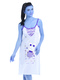

Original height, width, and channels of each image: 80 60 3


In [22]:
import imageio
import os
import glob
from collections import Counter
import random
myseed = 12345  # set a random seed for reproducibility

from google.colab.patches import cv2_imshow

base_path = './myntradataset/images/'

# let's take a look at one random image
# Assuming the structure inside 'images' folder is similar to 'food11', adjust if necessary
random_pic_path = random.choice(os.listdir(os.path.join(base_path, )))
pic = imageio.imread(os.path.join(base_path, random_pic_path))
cv2_imshow(pic)
height, width, channels = pic.shape
print(f'Original height, width, and channels of each image: {height} {width} {channels}')




## Setup Libaries and GPU

In [23]:
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset

# This is for the progress bar.
from tqdm.auto import tqdm
import random

In [24]:
# basic setup for PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [25]:
# we need here to resize the PIL image and transform it into Tensor.
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])

test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])